In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import re,nltk,swifter
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree

## 1. Load dataset

In [2]:
#For reading data, we have to put path of the csv data file.
df = pd.read_csv(r'C:\Users\kapil\OneDrive\Desktop\NLP_Uzair\Project\Reddit_Sarcasm_Detection-main\Reddit_Sarcasm_Detection-main\src\data\train-balanced-sarcasm.csv')
df = df.fillna('')
df = df[['label','comment','author','score','created_utc','parent_comment']]
df.head()

,label,comment,author,score,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,2,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,-4,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,3,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,-8,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,6,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## Data Cleaning (Comments) : 

In [3]:
#Set of stop words excluding some of the words which show negation since its necessary for sarcasm detection:
stops = set(stopwords.words('english')) - {'no','not','nor','against','above','below','off','own'}

#Function to clean text/comment:
def clean_text(comment):
    text = str(comment)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ',text)
    text = re.sub("<.*?>", " ", text)
    text = re.sub(r"[0-9]+"," ",text)
    text = re.sub(r"@[A-Za-z0-9]+"," ",text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\'t", ' not',text)
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    text = re.sub('[^A-Za-z0-9]+',' ', text)
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    text = ' '.join(token for token in tokenizer.tokenize(text.lower()) if token not in stops)
    text = text.lower().strip()
    return text

#cleaned comment will be stored in a new column:
df["cleaned_comment"] = df.swifter.apply(lambda x: clean_text(x["comment"]),axis=1)


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

## Test train split for model training:

In [4]:
#Its a standard 80-20 split
train_x, val_x,train_y , val_y = train_test_split(df.drop('label',axis=1),df['label'],random_state=123,test_size=0.20)#

In [5]:
train_x.head()

,comment,author,score,created_utc,parent_comment,cleaned_comment
472809,Looks like some kind of ficus (fig tree) but I...,SloightlyOnTheHuh,2,2015-12-05 17:17:48,I like the look of this and thought about repl...,looks like kind ficus fig tree could not tell
59081,Donald the reality TV star does care about TV ...,rk119,1,2016-10-21 15:51:05,About 71 million watch final presidential deba...,donald reality tv star care tv ratings
5664,me irl,PixelPickaxe,1,2016-11-27 18:34:25,How much you want to bet that the artist was m...,irl
600959,Yo creia que su programa consistia en ser vene...,Mugut,1,2015-12-22 17:10:31,podemos,yo creia que su programa consistia en ser vene...
961633,"I like how one seller is selling it ""New"" with...",TehAdmral,2,2012-02-29 00:32:30,"""I wanna play Pokemon Yellow again, its probab...",like one seller selling new no box


In [6]:
train_txt = train_x['cleaned_comment']
val_txt = val_x['cleaned_comment']

# TF-IDF & LogisticRegression (wt only comments)

In [7]:
# unigram and bigram vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=9000)

#Initializing logistic regression classifier
clf = LogisticRegression(random_state=123,n_jobs=6,verbose=1,max_iter = 500)

#defining pipeline which feeds data to tfidf first and then to Logistic Regressor
tfidf_log_reg_pipeline =  Pipeline([('tf_idf',tfidf_vectorizer),('logit',clf)])


In [8]:
#fitting model
%%time
tfidf_log_reg_pipeline.fit(train_txt,train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   25.3s finished


Wall time: 1min 7s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=9000, min_df=5,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(max_iter=500, n_jobs=6, random_state=123,
                                    verbose=1))])

In [9]:
#predicting values
%%time
val_predict = tfidf_log_reg_pipeline.predict(val_txt)
#calculating accuracy
accuracy_score(val_y,val_predict)
#0.6832358722970114

Wall time: 5.78 s


0.6833097553495642

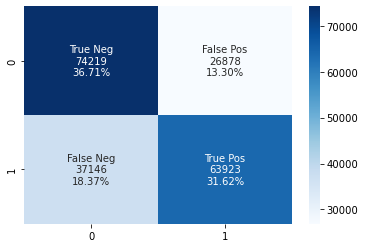

In [10]:
#Plotting confusion matrix for the same
def plot_conf_mat(val_y,val_predict):
    log_regression_conf_mat = confusion_matrix(val_y,val_predict)
    # sn.heatmap(log_regression_conf_mat, annot=True,cmap='Blues')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    log_regression_conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        log_regression_conf_mat.flatten()/np.sum(log_regression_conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(log_regression_conf_mat, annot=labels, fmt='', cmap='Blues')
plot_conf_mat(val_y,val_predict)

# TF_IDF & Logistic Regression (Wt parent & child comment)

In [11]:
df["cleaned_parent_comment"] = df.swifter.apply(lambda x: clean_text(x["parent_comment"]),axis=1)
df['cleaned_parent_child_comment'] = df['cleaned_parent_comment'] +' '+ df['cleaned_comment']
df.head()

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

,label,comment,author,score,created_utc,parent_comment,cleaned_comment,cleaned_parent_comment,cleaned_parent_child_comment
0,0,NC and NH.,Trumpbart,2,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",nc nh,yeah get argument point would prefer lived nc ...,yeah get argument point would prefer lived nc ...
1,0,You do know west teams play against west teams...,Shbshb906,-4,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,know west teams play against west teams east t...,blazers mavericks wests seed not even carry go...,blazers mavericks wests seed not even carry go...
2,0,"They were underdogs earlier today, but since G...",Creepeth,3,2016-09-22 21:45:37,They're favored to win.,underdogs earlier today since gronk announceme...,favored win,favored win underdogs earlier today since gron...
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,-8,2016-10-18 21:03:47,deadass don't kill my buzz,meme not funny none new york nigga ones,deadass not kill buzz,deadass not kill buzz meme not funny none new ...
4,0,I could use one of those tools.,cush2push,6,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,could use one tools,yep confirm saw tool use made boy easports mut,yep confirm saw tool use made boy easports mut...


In [12]:
#standard train-test split:
train_x, val_x,train_y , val_y = train_test_split(df.drop('label',axis=1),df['label'],random_state=123,test_size=0.20)
train_txt = train_x['cleaned_parent_child_comment']
val_txt = val_x['cleaned_parent_child_comment']

In [13]:
%%time
# bigram and trigram vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=15000)
clf = LogisticRegression(random_state=123,n_jobs=6,verbose=1,max_iter = 500)

#defining pipeline which feeds data to tfidf first and then to Logistic Regressor
tfidf_log_reg_pipeline =  Pipeline([('tf_idf',tfidf_vectorizer),('logit',clf)])

#fitting model
tfidf_log_reg_pipeline.fit(train_txt,train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   37.6s finished


Wall time: 2min 41s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=15000, min_df=10,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(max_iter=500, n_jobs=6, random_state=123,
                                    verbose=1))])

In [14]:
#predicting values
%%time
val_predict = tfidf_log_reg_pipeline.predict(val_txt)
#calculating accuracy
accuracy_score(val_y,val_predict)
#0.6568940204543758

Wall time: 14.9 s


0.6595174262734584

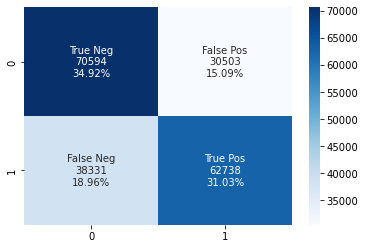

In [15]:
#Plotting confusion matrix for the same
plot_conf_mat(val_y,val_predict)

# TF-IDF & Decision tree


In [16]:
# unigram and bigram vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=9000)

#Initializing DecisionTree Classifier
dt = tree.DecisionTreeClassifier(max_depth=256,criterion="entropy",splitter="random")

#defining pipeline which feeds data to tfidf first and then to DecisionTreeClassifier
tfidf_dt_reg_pipeline =  Pipeline([('tf_idf',tfidf_vectorizer),('logit',dt)])

In [17]:
#fitting model
%%time
tfidf_dt_reg_pipeline.fit(train_txt,train_y)

Wall time: 53min 18s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=9000, min_df=5,
                                 ngram_range=(1, 2))),
                ('logit',
                 DecisionTreeClassifier(criterion='entropy', max_depth=256,
                                        splitter='random'))])

In [18]:
#predicting values
%%time
val_predict = tfidf_dt_reg_pipeline.predict(val_txt)
#calculating accuracy
accuracy_score(val_y,val_predict)
#0.6415905641127728
#0.5957975129349149

Wall time: 4.97 s


0.5957975129349149

# TF-IDF & Random Forest

In [19]:
# unigram and bigram vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 6,max_features = 12000)

#Initializing RandomForest Classifier
rf = RandomForestClassifier(max_depth = 512, n_estimators = 380, random_state = 123, n_jobs = 6, verbose = 1)

#defining pipeline which feeds data to tfidf first and then to RandomForestClassifier
tfidf_rf_reg_pipeline =  Pipeline([('tf_idf',tfidf_vectorizer),('logit',rf)])

In [20]:
#fitting model
%%time
tfidf_rf_reg_pipeline.fit(train_txt,train_y)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 91.2min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 220.4min


Wall time: 6h 22min 32s


[Parallel(n_jobs=6)]: Done 380 out of 380 | elapsed: 381.6min finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=12000, min_df=6,
                                 ngram_range=(1, 2))),
                ('logit',
                 RandomForestClassifier(max_depth=512, n_estimators=380,
                                        n_jobs=6, random_state=123,
                                        verbose=1))])

In [21]:
#predicting values
%%time
val_predict = tfidf_rf_reg_pipeline.predict(val_txt)

#Calculating accuracy
accuracy_score(val_y,val_predict)
#0.6475816902941147

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   21.5s


Wall time: 1min 6s


[Parallel(n_jobs=6)]: Done 380 out of 380 | elapsed:   49.1s finished


0.6475816902941147

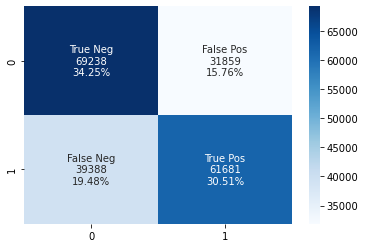

In [22]:
#Plotting confusion matrix for the same
plot_conf_mat(val_y,val_predict)